In [ ]:
#====================================================================
#-- Project      : EE239 Final Project
#-- File Name    : CNN_For_EEG.ipynb
#-- Description  : EEG signal processing by CNN
#-- Date         : 03/13/2018
#-- Author       : Xingyi Chen
#====================================================================

# Subject 1

In [4]:
import tensorflow as tf
import numpy as np 
import h5py
import matplotlib.pyplot as plt

A01T = h5py.File('A01T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)


In [2]:
def get_train_test(X, y, num_test = 50, num_train = 238, num_val = 50, 
                   subtract_mean=True):
   
    mask = list(range(num_train))
    X_train = X[mask]
    y_train = y[mask]
    mask = list(range(num_train,num_train+num_test))
    X_test = X[mask]
    y_test = y[mask]
    
    #mask = list(range(num_train-num_val))
    #X_train = X_train0[mask]
    #y_train = y_train0[mask]
    #mask = list(range(num_train-num_val,num_train))
    #X_val = X_train0[mask]
    #y_val = y_train0[mask]

#     if subtract_mean:
#         mean_image = np.mean(X_train, axis=0)
#         X_train -= mean_image
#         X_val -= mean_image
#         X_test -= mean_image
        
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_test': X_test, 'y_test': y_test,
    }

In [3]:
# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D,MaxPooling2D, AveragePooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import SGD

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)

Using TensorFlow backend.


(238, 4)
(50, 4)


In [6]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = [0]

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(self.times[-1]+time.time() - self.epoch_time_start)
        
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.testaccuracy = []

    def on_epoch_end(self, batch, logs={}):
        self.testaccuracy.append(logs.get('val_acc'))

# Shallow ConvNet from the paper

In [18]:
X_train1 = np.expand_dims(X_train,-1)
#X_val1 = np.expand_dims(X_val,-1)
X_test1 = np.expand_dims(X_test,-1)

print(X_train1.shape)
#print(X_train1.shape[1:])
print(X_test1.shape)
#print(X_val1.shape[1:])

(238, 1000, 22, 1)
(50, 1000, 22, 1)


In [25]:
epochs = 20
batch_size = 80

model = Sequential()

# 1st cnn block:

# 1000*22*1
model.add(Conv2D(filters=40, kernel_size=(25,1), strides=(1,1),activation='relu', padding='valid',kernel_initializer='uniform',
                 input_shape=(1000,22,1)))
# 991*22*25
model.add(Reshape((22,40,976), input_shape=(976,22,40)))
# 22*25*991
model.add(Conv2D(filters=976, kernel_size=(22,1), strides=1,activation='relu',padding='valid',kernel_initializer='uniform'))
# 1*25*991
model.add(Reshape((976,40,1), input_shape=(1,40,976)))
# 991*25*1
model.add(AveragePooling2D(pool_size=(75,1),strides=(15,1)))

model.add(Flatten()) 
model.add(Dense(num_classes,activation='softmax'))  

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

model.fit(X_train1, y_train, batch_size=batch_size,validation_data=(X_test1,y_test),epochs=epochs,verbose=1)
scores = model.evaluate(X_test1, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 976, 22, 40)       1040      
_________________________________________________________________
reshape_15 (Reshape)         (None, 22, 40, 976)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 40, 976)        20957648  
_________________________________________________________________
reshape_16 (Reshape)         (None, 976, 40, 1)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 61, 40, 1)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 2440)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 9764      
Total para

# Deep ConvNet from the paper

In [54]:
X_train1 = np.expand_dims(X_train,-1)
X_val1 = np.expand_dims(X_val,-1)
X_test1 = np.expand_dims(X_test,-1)

print(X_train1.shape)
#print(X_train1.shape[1:])
print(X_val1.shape)
#print(X_val1.shape[1:])

(188, 1000, 22, 1)
(50, 1000, 22, 1)


In [85]:
epochs = 40
batch_size = 80

model = Sequential()

# 1st cnn block:

# 1000*22*1
model.add(Conv2D(filters=25, kernel_size=(10,1), strides=(1,1),activation='relu', padding='valid',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform',
                 input_shape=(1000,22,1)))
# 991*22*25
model.add(Reshape((22,25,991), input_shape=(991,22,25)))
# 22*25*991
model.add(Conv2D(filters=991, kernel_size=(22,1), strides=1,activation='relu',padding='valid',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))
# 1*25*991
model.add(Reshape((991,25,1), input_shape=(1,25,991)))
# 991*25*1
model.add(MaxPooling2D(pool_size=(3,1),padding='valid'))

# 2nd cnn block:
# 331*25*1     
model.add(Conv2D(filters=50, kernel_size=(10,25), strides=1,activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))
# 321*1*50
model.add(Reshape((321,50,1), input_shape=(321,1,50)))
# 321*50*1
model.add(MaxPooling2D(pool_size=(3,1),padding='valid'))

# 3rd cnn block:
# 107*50*1
model.add(Conv2D(filters=100, kernel_size=(10,50), strides=1,activation='relu',kernel_regularizer = regularizers.l2(0.01),padding='valid',kernel_initializer='uniform'))
# 98*1*100
model.add(Reshape((98,100,1), input_shape=(98,1,100)))
# 98*100*1
model.add(MaxPooling2D(pool_size=(3,1),padding='valid'))

# 4th cnn block:
# 32*100*1
model.add(Conv2D(filters=200, kernel_size=(10,100), strides=1,activation='relu',kernel_regularizer = regularizers.l2(0.01),padding='valid',kernel_initializer='uniform'))
# 23*1*200
model.add(Reshape((23,200,1), input_shape=(23,1,200)))
# 23*200*1
model.add(MaxPooling2D(pool_size=(3,1),padding='valid'))
# 8*200*1


# Linear Classification(dense Layer)
model.add(Flatten())  

#model.add(Dense(4096,activation='relu'))  
#model.add(Dropout(0.5)) 
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])  
model.summary()  

model.fit(X_train1, y_train, batch_size=batch_size,validation_data=(X_test1,y_test),epochs=epochs,verbose=1)
scores = model.evaluate(X_test1, y_test, verbose=1)

#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 991, 22, 25)       275       
_________________________________________________________________
reshape_98 (Reshape)         (None, 22, 25, 991)       0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 1, 25, 991)        21606773  
_________________________________________________________________
reshape_99 (Reshape)         (None, 991, 25, 1)        0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 330, 25, 1)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 321, 1, 50)        12550     
_________________________________________________________________
reshape_100 (Reshape)        (None, 321, 50, 1)        0         
__________

# Alexnet

# 1. A single trial of AlexNet: the model is bad for the EEG data

In [11]:
epochs = 10  
batch_size = 32

model = Sequential()

# 1st cnn layer: 96 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=96, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),epochs=epochs)
scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 248, 96)           23328     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 123, 96)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 123, 256)          123136    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 61, 256)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 61, 384)           295296    
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 61, 384)           442752    
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 61, 256)           295168    
__________

# 2. change the some filter size of the AlexNet layers: It's more suitable for the data

In [12]:
epochs = 30  
batch_size = 32

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),epochs=epochs)
scores = model.evaluate(X_test, y_test, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 61, 256)           196864    
__________

# 3(1). Add one convolutional layer 

In [86]:
epochs = 30  
batch_size = 80

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

# add the layer here
model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),epochs=epochs)
scores = model.evaluate(X_test, y_test, verbose=1)

#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 61, 256)           196864    
__________

# 3(2). Increase epoch to see the trend of validation accuracy

In [92]:
epochs = 100  
batch_size = 80

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=1)

#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 61, 256)           196864    
__________

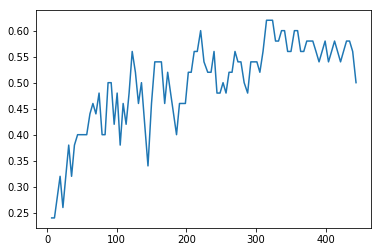

In [93]:
times[1:]
plt.plot(times[1:],acc_callback.testaccuracy)

# 3(3). Change activation functions: elu is not good for the EEG data

In [94]:
epochs = 30  
batch_size = 80

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='elu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='elu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='elu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='elu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='elu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='elu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),epochs=epochs)
scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 61, 256)           196864    
__________

# 4(1). Other ways to increase validation accuracy--add regularization doesn't change the accuracy

In [96]:
epochs = 100  
batch_size = 80

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_regularizer = regularizers.l2(0.01),kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu',kernel_regularizer = regularizers.l2(0.01)))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu',kernel_regularizer = regularizers.l2(0.01)))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 61, 256)           196864    
__________

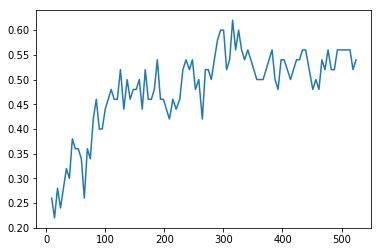

In [97]:
times[1:]
plt.plot(times[1:],acc_callback.testaccuracy)

# 4(2). Other ways to increase validation accuracy--change batch size to 64: the best accuracy is 62% and it's more stable than the batch size of 80

In [102]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 61, 384)           221568    
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 61, 256)           295168    
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 61, 256)           196864    
__________

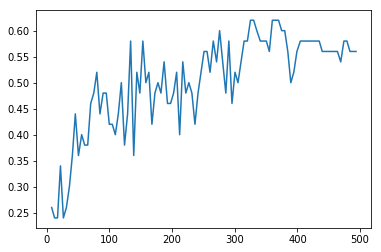

In [103]:
times[1:]
plt.plot(times[1:],acc_callback.testaccuracy)

# 4(3). Other ways to increase validation accuracy--add one deep layer: the highest accuracy reaches 66%

In [104]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 61, 384)           221568    
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 61, 256)           295168    
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 61, 256)           196864    
__________

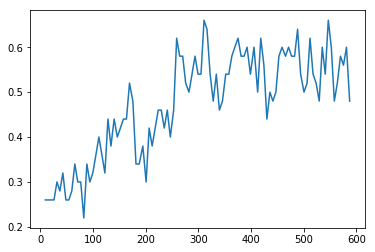

In [105]:
times[1:]
plt.plot(times[1:],acc_callback.testaccuracy)

# 4(4). Other ways to increase validation accuracy--add two deep layer: the highest accuracy drops 

In [29]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5)) 
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 61, 256)           196864    
__________

50/50 [==============================] - 0s 10ms/step


# 4(5). Add batch normalization to the network

In [28]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(BatchNormalization())
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5)) 
model.add(BatchNormalization())
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(BatchNormalization())
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 61, 256)           196864    
__________

238/238 [==============================] - 7s 30ms/step - loss: 1.4916 - acc: 0.8824 - val_loss: 11.9417 - val_acc: 0.2200
Epoch 100/100
50/50 [==============================] - 0s 9ms/step


# Subject 2

In [30]:
A01T = h5py.File('A02T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)


In [31]:
# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [32]:
# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [33]:
X_train1 = np.expand_dims(X_train,-1)
#X_val1 = np.expand_dims(X_val,-1)
X_test1 = np.expand_dims(X_test,-1)

print(X_train1.shape)
#print(X_train1.shape[1:])
print(X_test1.shape)
#print(X_val1.shape[1:])

(238, 1000, 22, 1)
(50, 1000, 22, 1)


In [34]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 61, 256)           196864    
__________

# Subject 3

In [35]:
A01T = h5py.File('A03T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [36]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 61, 256)           196864    
__________

# Subject 4

In [37]:
A01T = h5py.File('A04T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [38]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 61, 256)           196864    
__________

# Subject 5

In [39]:
A01T = h5py.File('A05T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [40]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 61, 256)           196864    
__________

# Subject 6

In [41]:
A01T = h5py.File('A06T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [42]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 61, 192)           0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 61, 256)           196864    
__________

# Subject 7

In [10]:
A01T = h5py.File('A07T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [11]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 61, 192)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 61, 384)           221568    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 61, 256)           196864    
__________

238/238 [==============================] - 8s 32ms/step - loss: 0.0718 - acc: 0.9748 - val_loss: 2.1074 - val_acc: 0.5800
Epoch 43/100
238/238 [==============================] - 8s 32ms/step - loss: 0.1079 - acc: 0.9580 - val_loss: 2.5555 - val_acc: 0.6000
Epoch 44/100
238/238 [==============================] - 8s 34ms/step - loss: 0.1400 - acc: 0.9454 - val_loss: 2.9327 - val_acc: 0.5000
Epoch 45/100
238/238 [==============================] - 7s 29ms/step - loss: 0.1471 - acc: 0.9370 - val_loss: 2.7958 - val_acc: 0.5400
Epoch 46/100
238/238 [==============================] - 7s 29ms/step - loss: 0.1147 - acc: 0.9538 - val_loss: 2.2834 - val_acc: 0.4600
Epoch 47/100
238/238 [==============================] - 7s 29ms/step - loss: 0.1202 - acc: 0.9664 - val_loss: 2.5251 - val_acc: 0.5000
Epoch 48/100
238/238 [==============================] - 7s 29ms/step - loss: 0.0647 - acc: 0.9832 - val_loss: 2.7998 - val_acc: 0.4800
Epoch 49/100
238/238 [==============================] - 7s 30ms/step

# Subject 8

In [8]:
A01T = h5py.File('A08T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [9]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 192)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 61, 384)           221568    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 256)           295168    
___________________________________________________________

238/238 [==============================] - 7s 28ms/step - loss: 1.3110 - acc: 0.3487 - val_loss: 1.3193 - val_acc: 0.4400
Epoch 39/100
238/238 [==============================] - 7s 28ms/step - loss: 1.1557 - acc: 0.5420 - val_loss: 1.3536 - val_acc: 0.3800
Epoch 40/100
238/238 [==============================] - 7s 28ms/step - loss: 1.0087 - acc: 0.5924 - val_loss: 1.6367 - val_acc: 0.4200
Epoch 41/100
238/238 [==============================] - 7s 28ms/step - loss: 0.9136 - acc: 0.5924 - val_loss: 1.4054 - val_acc: 0.3600
Epoch 42/100
238/238 [==============================] - 7s 29ms/step - loss: 0.7876 - acc: 0.6597 - val_loss: 1.6344 - val_acc: 0.4600
Epoch 43/100
238/238 [==============================] - 7s 29ms/step - loss: 0.7032 - acc: 0.7143 - val_loss: 1.8003 - val_acc: 0.4000
Epoch 44/100
238/238 [==============================] - 7s 29ms/step - loss: 0.6332 - acc: 0.7185 - val_loss: 2.0902 - val_acc: 0.4200
Epoch 45/100
238/238 [==============================] - 7s 28ms/step

238/238 [==============================] - 7s 29ms/step - loss: 12.1224 - acc: 0.2479 - val_loss: 11.9274 - val_acc: 0.2600
Epoch 99/100
238/238 [==============================] - 6s 27ms/step - loss: 12.1224 - acc: 0.2479 - val_loss: 11.9274 - val_acc: 0.2600
Epoch 100/100
50/50 [==============================] - 0s 9ms/step


# Subject 9

In [12]:
A01T = h5py.File('A09T_slice.mat', 'r') 
X = np.copy(A01T['image']) 
y = np.copy(A01T['type']) 
y = y[0,0:X.shape[0]:1] 
y = np.asarray(y, dtype=np.int32)

# 288 trials per session
# 25 channels (the ﬁrst 22 are EEG and the last 3 are EOG signals)
# The data is sampled at 250Hz, and so 1000 corresponds to 4s of data for each trial.
print(X.shape)
print(y.shape)

# get rid of the EOG signal
X = X[:,:22,:]
print(X.shape)

# get rif of NaN
y = np.asarray(y, dtype=np.float32)-769
y = y[:,None]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
# X[n_trials, n_steps, n_inputs]
X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

# There are 4 classes  
num_classes = 4  

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [13]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test, y_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 61, 192)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 61, 384)           221568    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 61, 256)           295168    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 61, 256)           196864    
__________

238/238 [==============================] - 8s 34ms/step - loss: 0.4294 - acc: 0.8697 - val_loss: 2.6202 - val_acc: 0.5000
Epoch 43/100
238/238 [==============================] - 8s 34ms/step - loss: 0.4519 - acc: 0.8109 - val_loss: 2.4164 - val_acc: 0.4800
Epoch 44/100
238/238 [==============================] - 7s 28ms/step - loss: 0.2172 - acc: 0.9160 - val_loss: 3.4641 - val_acc: 0.4600
Epoch 45/100
238/238 [==============================] - 7s 29ms/step - loss: 0.1902 - acc: 0.9286 - val_loss: 2.5618 - val_acc: 0.5600
Epoch 46/100
238/238 [==============================] - 7s 31ms/step - loss: 0.1952 - acc: 0.9370 - val_loss: 2.8894 - val_acc: 0.4600
Epoch 47/100
238/238 [==============================] - 7s 30ms/step - loss: 0.1710 - acc: 0.9538 - val_loss: 3.0153 - val_acc: 0.4800
Epoch 48/100
238/238 [==============================] - 6s 27ms/step - loss: 0.1964 - acc: 0.9328 - val_loss: 2.3042 - val_acc: 0.5600
Epoch 49/100
238/238 [==============================] - 6s 26ms/step